In [1]:
# Author: Stefania Di Tommaso (sditom@stanford.edu)
# Guide: see HowToDownloadMosaics.docx

import requests
import os
import numpy as np
import pandas as pd
from osgeo import gdal # to crop tile
from shapely.geometry import box, Point
import shutil
import imageio
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
################################################################################
##  Objective: Download MOSAICS RGB given a AOI defined in the bbox variable  ##
################################################################################


####----------------------------Settings------------------------------------####
# Set API key
os.environ['PL_API_KEY'] = '35922faaba86474598eedb60ef2fa78a'
my_auth_key = os.getenv('PL_API_KEY')

# Set AOI file - one large rectangle
# GHANA - UDRY
base_dir = os.path.join('..', 'data', 'planet', 'ghana', 'udry')
bbox_df = pd.read_csv(os.path.join(base_dir, 'bbox_entire_region.csv'), dtype=str)
geojsonFolder = os.path.join(base_dir, 'input_locations', 'geojson')

# Set years and months of interest
year = '_2017_'
months = ['_{}_'.format(str(x).zfill(2)) for x in np.arange(1, 13)]

# Set output Folder
outFolder = os.path.join(base_dir, 'temp_monthly_mosaics')
outFolder_renamed = os.path.join(base_dir, 'monthly_mosaics_renamed') # FINAL FOLDER IF RENAMING FILES

# Set folders used in clipping/merging client side
outFolder_clipped = os.path.join(base_dir, 'temp_monthly_mosaics_renamed_clipped') # TEMPORARY
outFolder_final = os.path.join(base_dir, 'monthly_mosaics_renamed_clipped_merged') # FINAL FOLDER IF CLIP-MERGE FILES
################################################################################

In [9]:
region.exterior.xy

(array('d', [0.509137239441279, 0.509137239441279, 0.0547312185193094, 0.0547312185193094, 0.509137239441279]),
 array('d', [9.430329493919233, 10.039716796554652, 10.039716796554652, 9.430329493919233, 9.430329493919233]))

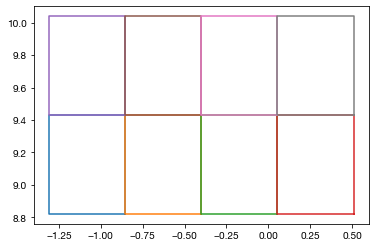

In [11]:
for i, row in bbox_df.iterrows():
    region = box(float(row['min_lon']), float(row['min_lat']), float(row['max_lon']), float(row['max_lat']))
    x, y = region.exterior.xy
    plt.plot(x, y)
plt.show()

In [3]:
##########------- List All mosaics available with your account------############
headers = {
    'Authorization': 'api-key' + ' ' + my_auth_key,
}
response = requests.get('https://api.planet.com/basemaps/v1/mosaics', headers=headers)
print(response.status_code)

if response.status_code == 200: # ok, proceed
    # print(response.json())
    mosaic_names = []
    for thisMosaic in response.json()['mosaics']:
        mosaic_names.append(thisMosaic['name'])
    # print('All Available mosaics: \n {}'.format(mosaic_names))
else:
    error_msg = 'Error code {}: {}'.format(response.status_code, response.text)
    print(error_msg)
    os.sys.exit(1)
################################################################################

200


In [4]:
########---------- Subset Mosaics to Month-year of interest ----------##########

my_mosaics_year = [m for m in mosaic_names if year in m]
# subset to  January, April, July, October
my_mosaics = []
for mos in my_mosaics_year:
    for mon in months:
        if mon in mos:
            my_mosaics.append(mos)
# print('mosaics: 2018 Jan,Apr,Jul,Oct:  {} \n'.format(my_mosaics))
################################################################################

In [6]:
############## ---------- Retrive List of AOI ----------########################
# print(bbox_df.head(3))
bbox_df["bbox"] = bbox_df["min_lon"] + ',' +\
                  bbox_df["min_lat"] + ',' +\
                  bbox_df["max_lon"] + ',' +\
                  bbox_df["max_lat"]

bbox_list = bbox_df["bbox"].tolist()
bbox_names_list = bbox_df["image_id"].tolist()
# print('AOIs: {} \n'.format(len(bbox_list)))
################################################################################

In [7]:
def tileSearch(mosaic, bbox):
    # Do Tile Search and print on screen
    search_cmd = 'planet mosaics search' + ' ' + mosaic + ' ' + '--bbox' + ' ' + bbox + ' ' + '| jq ."items[].id"'
    output = os.popen(search_cmd).read()
    tile_list = output.split('\n')[:-1]
    print('        {0}: tiles to download:{1}'.format(mosaic,tile_list))


def tileDownload(mosaic, bbox, outdir):
    # save each mosaic-tiles in a separate folder named as year_month
    year_month = '_'.join(mosaic.split('_')[2:4])
    outputFolder = os.path.join(outFolder, outdir, year_month)
    if not os.path.exists(outputFolder):
        # print('Create dir {}..'.format(outputFolder))
        os.makedirs(outputFolder)
    download_cmd = 'planet mosaics download' + ' ' + mosaic + ' ' + '--bbox' + ' ' + bbox + ' ' + '--dest'+ ' ' + outputFolder
    print(download_cmd)
    output = os.popen(download_cmd).read()


def rename_files(outTempFolder, outFinalFolder):
    ######## Script for renaming all the files and save them in a unique folder #########
    ## rename: Aoi_year_month_tileId.tif
    for direc, subdir, listfilename in os.walk(outTempFolder):
        for filename in listfilename:
            dir_yearmonth = os.path.split(direc)[1] #'2018_10'
            dir_aoi = os.path.split(os.path.split(direc)[0])[1] #'7068978'
            new_filename = '_'.join([dir_aoi, dir_yearmonth, filename])
            # print(new_filename)
            src = os.path.join(direc, filename)
            if not os.path.exists(outFinalFolder):
                os.makedirs(outFinalFolder)
            dst = os.path.join(outFinalFolder, new_filename)
            os.rename(src, dst)


def delete_empty_folders(outTempFolder):
    ## Starting from outTempFolder deletes all empty folders
    # Note: after the renaming the files have been moved.
    # so folders should be all empty. if one is not, means something went wrong with renaming.
    # so checking if they are empty before deletinf is a sanity check
    # that all data have been saved in the final folder
    for root, dirs, files in os.walk(outTempFolder, topdown=False):
        for name in dirs:
            thisDir = os.path.join(root, name)
            if not os.listdir(thisDir):
#                 print(thisDir + ' is empty. It will be removed')
                os.rmdir(thisDir)
    # if all folders are empty -> remove Parent folder
    if not os.listdir(outTempFolder):
#         print(outTempFolder + ' is empty. It will be removed')
        os.rmdir(outTempFolder)


def clipQuads(inFolder, geoFolder, outFolder):
    # Clip downloaded quads using AOI geojson files
    bbox_names_list = list(set([f.split('_')[0] for f in os.listdir(inFolder)]))
    print('start clipping')
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    for thisBbox in bbox_names_list:
        thisGeojson = [os.path.join(geoFolder, f) for f in os.listdir(geoFolder) if f.startswith(thisBbox)][0]
        # Find files for this AOI
        thisFiles = [f for f in os.listdir(inFolder) if f.startswith(thisBbox+'_')]
        for thisFile in thisFiles:
            source = os.path.join(inFolder, thisFile)
            output = os.path.join(outFolder, thisFile)
            gdal.Warp(srcDSOrSrcDSTab=source, destNameOrDestDS=output, cutlineDSName=thisGeojson,
                      cropToCutline=True)
    print('done clipping')


def mergeQuads(inFolder, outFolder):
    # merge tiles that belong to same AOI and same Date (year-month)
    bbox_names_list = list(set([f.split('_')[0] for f in os.listdir(inFolder)]))
    date_list = list(set(['_'.join(f.split('_')[1:3]) for f in os.listdir(inFolder)]))
    bbox_date_list = [b+'_'+d for b in bbox_names_list for d in date_list]
    if not os.path.exists(outFolder):
        os.makedirs(outFolder)
    for thisBboxDate in bbox_date_list:
        thisFiles = [f for f in os.listdir(inFolder) if f.startswith(thisBboxDate+'_')] # list all the files of a same bbox and same date
        input = [os.path.join(inFolder, f) for f in thisFiles]
        output = os.path.join(outFolder, thisBboxDate + '.tif')
        gdal.Warp(srcDSOrSrcDSTab = input, destNameOrDestDS = output)

Now run `python generate_geojson.py`.

In [9]:
for j in range(8):
#############################-----------MAIN-------#############################
    start = j
    end = j+1 #len(bbox_list)

    # for i, thisbbox in enumerate(bbox_list[:]):
    for i in range(start, end):
        thisbbox = bbox_list[i]
        print('{0}/{1} AOI:{2}, bbox:{3}'.format(i+1, len(bbox_list), bbox_names_list[i], thisbbox))
        outdir = bbox_names_list[i] # name of the AOI
        for thisMosaic in my_mosaics[:]:
    #         tileSearch(thisMosaic,thisbbox) # not need to run-just sanity check
            tileDownload(thisMosaic, thisbbox, outdir) # uncomment when ready to start download!

    ## Client side processing: Rename, clip, merge
    rename_files(outFolder, outFolder_renamed)
    delete_empty_folders(outFolder)

    clipQuads(outFolder_renamed, geojsonFolder, outFolder_clipped)

    # merge tiles that belong to same AOI and same Date (year-month)
    bbox_names_list2 = ['region{}'.format(j)]
    date_list = ['2017_{}'.format(str(x).zfill(2)) for x in range(1,13)]
    bbox_date_list = [b+'_'+d for b in bbox_names_list2 for d in date_list]

    if not os.path.exists(outFolder_final):
        os.makedirs(outFolder_final)

    for thisBboxDate in bbox_date_list:
        print(thisBboxDate)
        thisFiles = [f for f in os.listdir(outFolder_clipped) if f.startswith(thisBboxDate+'_')] # list all the files of a same bbox and same date
        warp_input = [os.path.join(outFolder_clipped, f) for f in thisFiles]
        warp_output = os.path.join(outFolder_final, thisBboxDate + '.tif')
        gdal.Warp(srcDSOrSrcDSTab = warp_input, destNameOrDestDS = warp_output)
        
    # delete temp folders - especially monthly_mosaics_renamed
    shutil.rmtree(os.path.join(base_dir, 'monthly_mosaics_renamed'))
    shutil.rmtree(os.path.join(base_dir, 'temp_monthly_mosaics_renamed_clipped'))

1/8 AOI:region0, bbox:-1.308486844246599,8.820942191283814,-0.8540808233246294,9.430329493919233
planet mosaics download global_monthly_2017_01_mutate_mosaic --bbox -1.308486844246599,8.820942191283814,-0.8540808233246294,9.430329493919233 --dest ../data/planet/ghana/udry/temp_monthly_mosaics/region0/2017_01
planet mosaics download global_monthly_2017_02_mosaic --bbox -1.308486844246599,8.820942191283814,-0.8540808233246294,9.430329493919233 --dest ../data/planet/ghana/udry/temp_monthly_mosaics/region0/2017_02
planet mosaics download global_monthly_2017_03_mosaic --bbox -1.308486844246599,8.820942191283814,-0.8540808233246294,9.430329493919233 --dest ../data/planet/ghana/udry/temp_monthly_mosaics/region0/2017_03
planet mosaics download global_monthly_2017_04_mosaic --bbox -1.308486844246599,8.820942191283814,-0.8540808233246294,9.430329493919233 --dest ../data/planet/ghana/udry/temp_monthly_mosaics/region0/2017_04
planet mosaics download global_monthly_2017_05_mosaic --bbox -1.30848684

start clipping
done clipping
region2_2017_01
region2_2017_02
region2_2017_03
region2_2017_04
region2_2017_05
region2_2017_06
region2_2017_07
region2_2017_08
region2_2017_09
region2_2017_10
region2_2017_11
region2_2017_12
4/8 AOI:region3, bbox:0.0547312185193094,8.820942191283814,0.509137239441279,9.430329493919233
planet mosaics download global_monthly_2017_01_mutate_mosaic --bbox 0.0547312185193094,8.820942191283814,0.509137239441279,9.430329493919233 --dest ../data/planet/ghana/udry/temp_monthly_mosaics/region3/2017_01
planet mosaics download global_monthly_2017_02_mosaic --bbox 0.0547312185193094,8.820942191283814,0.509137239441279,9.430329493919233 --dest ../data/planet/ghana/udry/temp_monthly_mosaics/region3/2017_02
planet mosaics download global_monthly_2017_03_mosaic --bbox 0.0547312185193094,8.820942191283814,0.509137239441279,9.430329493919233 --dest ../data/planet/ghana/udry/temp_monthly_mosaics/region3/2017_03
planet mosaics download global_monthly_2017_04_mosaic --bbox 0.05

planet mosaics download global_monthly_2017_12_mosaic --bbox -0.8540808233246294,9.430329493919233,-0.39967480240265996,10.039716796554652 --dest ../data/planet/ghana/udry/temp_monthly_mosaics/region5/2017_12
start clipping
done clipping
region5_2017_01
region5_2017_02
region5_2017_03
region5_2017_04
region5_2017_05
region5_2017_06
region5_2017_07
region5_2017_08
region5_2017_09
region5_2017_10
region5_2017_11
region5_2017_12
7/8 AOI:region6, bbox:-0.39967480240265996,9.430329493919233,0.0547312185193094,10.039716796554652
planet mosaics download global_monthly_2017_01_mutate_mosaic --bbox -0.39967480240265996,9.430329493919233,0.0547312185193094,10.039716796554652 --dest ../data/planet/ghana/udry/temp_monthly_mosaics/region6/2017_01
planet mosaics download global_monthly_2017_02_mosaic --bbox -0.39967480240265996,9.430329493919233,0.0547312185193094,10.039716796554652 --dest ../data/planet/ghana/udry/temp_monthly_mosaics/region6/2017_02
planet mosaics download global_monthly_2017_03_m

In [ ]:
# why were some images not clipped?
img_names = os.listdir('../data/planet/ghana/udry/monthly_mosaics_renamed/')

not_clipped = []
for img_name in img_names:
    if not os.path.exists(os.path.join(
        '../data/planet/ghana/udry/temp_monthly_mosaics_renamed_clipped/', img_name)):
        not_clipped.append(img_name)
        print(img_name, "not in clipped folder.")

#### Clip small tiles from entire region

In [10]:
# first, figure out what regions each tile belongs to
bbox_csv_path = '../data/planet/ghana/udry/bbox_tiles_overlap.csv'
region_csv_path = '../data/planet/ghana/udry/bbox_entire_region.csv'

bbox_df = pd.read_csv(bbox_csv_path)
bbox_df['image_id'] = bbox_df['image_id'].astype(str).str.zfill(5)
region_df = pd.read_csv(region_csv_path)
        
region_geoms = []
for i, region_row in region_df.iterrows():
    region_min_lon = region_row['min_lon']
    region_min_lat = region_row['min_lat']
    region_max_lon = region_row['max_lon']
    region_max_lat = region_row['max_lat']
    
    region_box = box(region_min_lon, region_min_lat,
                     region_max_lon, region_max_lat)
    region_geoms.append(region_box)

which_region = []
split_between_regions = []
for j, bbox_row in bbox_df.iterrows():
    found_region = False
    bbox_min_lon = bbox_row['min_lon']
    bbox_min_lat = bbox_row['min_lat']
    bbox_max_lon = bbox_row['max_lon']
    bbox_max_lat = bbox_row['max_lat']
    
    bbox_geom = box(bbox_min_lon, bbox_min_lat, bbox_max_lon, bbox_max_lat)
    for i, region_geom in enumerate(region_geoms):
        if bbox_geom.within(region_geom):
            which_region.append(i)
            found_region = True
    
    if not found_region:
        bbox_within_regions = []
        for x in [bbox_min_lon, bbox_max_lon]:
            for y in [bbox_min_lat, bbox_max_lat]:
                vertex = Point(x,y)
                for i, region_geom in enumerate(region_geoms):
                    if vertex.within(region_geom):
                        bbox_within_regions.append(i)
                        
        if len(bbox_within_regions) == 0:
            print(bbox_row['image_id'])
        which_region.append(sorted(list(set(bbox_within_regions))))
        split_between_regions.append(bbox_row['image_id'])

In [12]:
# then clip from each region
img_dir = '../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/'
geojson_dir = '../data/planet/ghana/udry/input_locations/geojson'
save_dir = '../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged'

months = ['2017_{}'.format(str(x).zfill(2)) for x in np.arange(1, 13)]
for month in months:
    if not os.path.exists(os.path.join(save_dir, month)):
        os.makedirs(os.path.join(save_dir, month))

img_files = []
for x in region_df['image_id'].values:
    for month in months:
        img_files.append(x + '_' + month + '.tif')


for j, bbox in enumerate(bbox_df['image_id'].values):
    bbox_geojson = [os.path.join(geojson_dir, f) for f in os.listdir(geojson_dir) 
                    if f.startswith(bbox)][0]
    print(bbox_geojson)
    bbox_in_regions = which_region[j]

    for month in months:
        if type(bbox_in_regions) == int:
            img_file = 'region{}_{}.tif'.format(bbox_in_regions, month)
            bbox_img_name = bbox + '_' + month + '.tif'
            source = os.path.join(img_dir, img_file)
            output = os.path.join(save_dir, month, bbox_img_name)
            gdal.Warp(srcDSOrSrcDSTab=source, 
                      destNameOrDestDS=output, 
                      cutlineDSName=bbox_geojson,
                      cropToCutline=True)
            
        else:
            for bbox_region in bbox_in_regions:
                img_file = 'region{}_{}.tif'.format(bbox_region, month)
                bbox_img_name = bbox + '_' + month + '_region{}.tif'.format(bbox_region)
                source = os.path.join(img_dir, img_file)
                output = os.path.join(save_dir, month, bbox_img_name)
                gdal.Warp(srcDSOrSrcDSTab=source, 
                          destNameOrDestDS=output, 
                          cutlineDSName=bbox_geojson,
                          cropToCutline=True)

../data/planet/ghana/udry/input_locations/geojson/00059.geojson
../data/planet/ghana/udry/input_locations/geojson/00060.geojson
../data/planet/ghana/udry/input_locations/geojson/00168.geojson
../data/planet/ghana/udry/input_locations/geojson/00169.geojson
../data/planet/ghana/udry/input_locations/geojson/00170.geojson
../data/planet/ghana/udry/input_locations/geojson/00171.geojson
../data/planet/ghana/udry/input_locations/geojson/00173.geojson
../data/planet/ghana/udry/input_locations/geojson/00272.geojson
../data/planet/ghana/udry/input_locations/geojson/00273.geojson
../data/planet/ghana/udry/input_locations/geojson/00276.geojson
../data/planet/ghana/udry/input_locations/geojson/00278.geojson
../data/planet/ghana/udry/input_locations/geojson/00279.geojson
../data/planet/ghana/udry/input_locations/geojson/00280.geojson
../data/planet/ghana/udry/input_locations/geojson/00282.geojson
../data/planet/ghana/udry/input_locations/geojson/00283.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/01673.geojson
../data/planet/ghana/udry/input_locations/geojson/01674.geojson
../data/planet/ghana/udry/input_locations/geojson/01675.geojson
../data/planet/ghana/udry/input_locations/geojson/01676.geojson
../data/planet/ghana/udry/input_locations/geojson/01677.geojson
../data/planet/ghana/udry/input_locations/geojson/01678.geojson
../data/planet/ghana/udry/input_locations/geojson/01679.geojson
../data/planet/ghana/udry/input_locations/geojson/01682.geojson
../data/planet/ghana/udry/input_locations/geojson/01683.geojson
../data/planet/ghana/udry/input_locations/geojson/01684.geojson
../data/planet/ghana/udry/input_locations/geojson/01685.geojson
../data/planet/ghana/udry/input_locations/geojson/01694.geojson
../data/planet/ghana/udry/input_locations/geojson/01695.geojson
../data/planet/ghana/udry/input_locations/geojson/01696.geojson
../data/planet/ghana/udry/input_locations/geojson/01698.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/02433.geojson
../data/planet/ghana/udry/input_locations/geojson/02434.geojson
../data/planet/ghana/udry/input_locations/geojson/02435.geojson
../data/planet/ghana/udry/input_locations/geojson/02442.geojson
../data/planet/ghana/udry/input_locations/geojson/02443.geojson
../data/planet/ghana/udry/input_locations/geojson/02444.geojson
../data/planet/ghana/udry/input_locations/geojson/02445.geojson
../data/planet/ghana/udry/input_locations/geojson/02446.geojson
../data/planet/ghana/udry/input_locations/geojson/02448.geojson
../data/planet/ghana/udry/input_locations/geojson/02449.geojson
../data/planet/ghana/udry/input_locations/geojson/02453.geojson
../data/planet/ghana/udry/input_locations/geojson/02454.geojson
../data/planet/ghana/udry/input_locations/geojson/02455.geojson
../data/planet/ghana/udry/input_locations/geojson/02458.geojson
../data/planet/ghana/udry/input_locations/geojson/02543.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/03105.geojson
../data/planet/ghana/udry/input_locations/geojson/03107.geojson
../data/planet/ghana/udry/input_locations/geojson/03108.geojson
../data/planet/ghana/udry/input_locations/geojson/03109.geojson
../data/planet/ghana/udry/input_locations/geojson/03119.geojson
../data/planet/ghana/udry/input_locations/geojson/03120.geojson
../data/planet/ghana/udry/input_locations/geojson/03121.geojson
../data/planet/ghana/udry/input_locations/geojson/03215.geojson
../data/planet/ghana/udry/input_locations/geojson/03216.geojson
../data/planet/ghana/udry/input_locations/geojson/03217.geojson
../data/planet/ghana/udry/input_locations/geojson/03218.geojson
../data/planet/ghana/udry/input_locations/geojson/03219.geojson
../data/planet/ghana/udry/input_locations/geojson/03228.geojson
../data/planet/ghana/udry/input_locations/geojson/03229.geojson
../data/planet/ghana/udry/input_locations/geojson/03230.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/04345.geojson
../data/planet/ghana/udry/input_locations/geojson/04346.geojson
../data/planet/ghana/udry/input_locations/geojson/04430.geojson
../data/planet/ghana/udry/input_locations/geojson/04431.geojson
../data/planet/ghana/udry/input_locations/geojson/04432.geojson
../data/planet/ghana/udry/input_locations/geojson/04434.geojson
../data/planet/ghana/udry/input_locations/geojson/04435.geojson
../data/planet/ghana/udry/input_locations/geojson/04436.geojson
../data/planet/ghana/udry/input_locations/geojson/04437.geojson
../data/planet/ghana/udry/input_locations/geojson/04441.geojson
../data/planet/ghana/udry/input_locations/geojson/04444.geojson
../data/planet/ghana/udry/input_locations/geojson/04445.geojson
../data/planet/ghana/udry/input_locations/geojson/04446.geojson
../data/planet/ghana/udry/input_locations/geojson/04454.geojson
../data/planet/ghana/udry/input_locations/geojson/04455.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/05233.geojson
../data/planet/ghana/udry/input_locations/geojson/05246.geojson
../data/planet/ghana/udry/input_locations/geojson/05247.geojson
../data/planet/ghana/udry/input_locations/geojson/05249.geojson
../data/planet/ghana/udry/input_locations/geojson/05310.geojson
../data/planet/ghana/udry/input_locations/geojson/05311.geojson
../data/planet/ghana/udry/input_locations/geojson/05323.geojson
../data/planet/ghana/udry/input_locations/geojson/05324.geojson
../data/planet/ghana/udry/input_locations/geojson/05325.geojson
../data/planet/ghana/udry/input_locations/geojson/05327.geojson
../data/planet/ghana/udry/input_locations/geojson/05328.geojson
../data/planet/ghana/udry/input_locations/geojson/05329.geojson
../data/planet/ghana/udry/input_locations/geojson/05330.geojson
../data/planet/ghana/udry/input_locations/geojson/05331.geojson
../data/planet/ghana/udry/input_locations/geojson/05332.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/06538.geojson
../data/planet/ghana/udry/input_locations/geojson/06748.geojson
../data/planet/ghana/udry/input_locations/geojson/06754.geojson
../data/planet/ghana/udry/input_locations/geojson/06863.geojson
../data/planet/ghana/udry/input_locations/geojson/06864.geojson
../data/planet/ghana/udry/input_locations/geojson/06971.geojson
../data/planet/ghana/udry/input_locations/geojson/06973.geojson
../data/planet/ghana/udry/input_locations/geojson/06974.geojson
../data/planet/ghana/udry/input_locations/geojson/06975.geojson
../data/planet/ghana/udry/input_locations/geojson/06976.geojson
../data/planet/ghana/udry/input_locations/geojson/07078.geojson
../data/planet/ghana/udry/input_locations/geojson/07079.geojson
../data/planet/ghana/udry/input_locations/geojson/07080.geojson
../data/planet/ghana/udry/input_locations/geojson/07081.geojson
../data/planet/ghana/udry/input_locations/geojson/07082.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/08295.geojson
../data/planet/ghana/udry/input_locations/geojson/08301.geojson
../data/planet/ghana/udry/input_locations/geojson/08303.geojson
../data/planet/ghana/udry/input_locations/geojson/08304.geojson
../data/planet/ghana/udry/input_locations/geojson/08305.geojson
../data/planet/ghana/udry/input_locations/geojson/08306.geojson
../data/planet/ghana/udry/input_locations/geojson/08311.geojson
../data/planet/ghana/udry/input_locations/geojson/08312.geojson
../data/planet/ghana/udry/input_locations/geojson/08401.geojson
../data/planet/ghana/udry/input_locations/geojson/08402.geojson
../data/planet/ghana/udry/input_locations/geojson/08403.geojson
../data/planet/ghana/udry/input_locations/geojson/08404.geojson
../data/planet/ghana/udry/input_locations/geojson/08405.geojson
../data/planet/ghana/udry/input_locations/geojson/08411.geojson
../data/planet/ghana/udry/input_locations/geojson/08412.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/09502.geojson
../data/planet/ghana/udry/input_locations/geojson/09503.geojson
../data/planet/ghana/udry/input_locations/geojson/09504.geojson
../data/planet/ghana/udry/input_locations/geojson/09505.geojson
../data/planet/ghana/udry/input_locations/geojson/09594.geojson
../data/planet/ghana/udry/input_locations/geojson/09595.geojson
../data/planet/ghana/udry/input_locations/geojson/09596.geojson
../data/planet/ghana/udry/input_locations/geojson/09597.geojson
../data/planet/ghana/udry/input_locations/geojson/09598.geojson
../data/planet/ghana/udry/input_locations/geojson/09600.geojson
../data/planet/ghana/udry/input_locations/geojson/09601.geojson
../data/planet/ghana/udry/input_locations/geojson/09602.geojson
../data/planet/ghana/udry/input_locations/geojson/09605.geojson
../data/planet/ghana/udry/input_locations/geojson/09628.geojson
../data/planet/ghana/udry/input_locations/geojson/09704.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/10560.geojson
../data/planet/ghana/udry/input_locations/geojson/10561.geojson
../data/planet/ghana/udry/input_locations/geojson/10562.geojson
../data/planet/ghana/udry/input_locations/geojson/10564.geojson
../data/planet/ghana/udry/input_locations/geojson/10576.geojson
../data/planet/ghana/udry/input_locations/geojson/10577.geojson
../data/planet/ghana/udry/input_locations/geojson/10578.geojson
../data/planet/ghana/udry/input_locations/geojson/10580.geojson
../data/planet/ghana/udry/input_locations/geojson/10581.geojson
../data/planet/ghana/udry/input_locations/geojson/10598.geojson
../data/planet/ghana/udry/input_locations/geojson/10601.geojson
../data/planet/ghana/udry/input_locations/geojson/10602.geojson
../data/planet/ghana/udry/input_locations/geojson/10603.geojson
../data/planet/ghana/udry/input_locations/geojson/10604.geojson
../data/planet/ghana/udry/input_locations/geojson/10669.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/11700.geojson
../data/planet/ghana/udry/input_locations/geojson/11710.geojson
../data/planet/ghana/udry/input_locations/geojson/11711.geojson
../data/planet/ghana/udry/input_locations/geojson/11779.geojson
../data/planet/ghana/udry/input_locations/geojson/11780.geojson
../data/planet/ghana/udry/input_locations/geojson/11781.geojson
../data/planet/ghana/udry/input_locations/geojson/11820.geojson
../data/planet/ghana/udry/input_locations/geojson/11821.geojson
../data/planet/ghana/udry/input_locations/geojson/11822.geojson
../data/planet/ghana/udry/input_locations/geojson/11823.geojson
../data/planet/ghana/udry/input_locations/geojson/11891.geojson
../data/planet/ghana/udry/input_locations/geojson/11892.geojson
../data/planet/ghana/udry/input_locations/geojson/11893.geojson
../data/planet/ghana/udry/input_locations/geojson/11894.geojson
../data/planet/ghana/udry/input_locations/geojson/11895.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/12695.geojson
../data/planet/ghana/udry/input_locations/geojson/12696.geojson
../data/planet/ghana/udry/input_locations/geojson/12697.geojson
../data/planet/ghana/udry/input_locations/geojson/12698.geojson
../data/planet/ghana/udry/input_locations/geojson/12775.geojson
../data/planet/ghana/udry/input_locations/geojson/12776.geojson
../data/planet/ghana/udry/input_locations/geojson/12777.geojson
../data/planet/ghana/udry/input_locations/geojson/12778.geojson
../data/planet/ghana/udry/input_locations/geojson/12779.geojson
../data/planet/ghana/udry/input_locations/geojson/12780.geojson
../data/planet/ghana/udry/input_locations/geojson/12781.geojson
../data/planet/ghana/udry/input_locations/geojson/12782.geojson
../data/planet/ghana/udry/input_locations/geojson/12783.geojson
../data/planet/ghana/udry/input_locations/geojson/12784.geojson
../data/planet/ghana/udry/input_locations/geojson/12791.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/13385.geojson
../data/planet/ghana/udry/input_locations/geojson/13386.geojson
../data/planet/ghana/udry/input_locations/geojson/13391.geojson
../data/planet/ghana/udry/input_locations/geojson/13392.geojson
../data/planet/ghana/udry/input_locations/geojson/13393.geojson
../data/planet/ghana/udry/input_locations/geojson/13394.geojson
../data/planet/ghana/udry/input_locations/geojson/13467.geojson
../data/planet/ghana/udry/input_locations/geojson/13468.geojson
../data/planet/ghana/udry/input_locations/geojson/13478.geojson
../data/planet/ghana/udry/input_locations/geojson/13479.geojson
../data/planet/ghana/udry/input_locations/geojson/13480.geojson
../data/planet/ghana/udry/input_locations/geojson/13484.geojson
../data/planet/ghana/udry/input_locations/geojson/13485.geojson
../data/planet/ghana/udry/input_locations/geojson/13486.geojson
../data/planet/ghana/udry/input_locations/geojson/13493.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/14919.geojson
../data/planet/ghana/udry/input_locations/geojson/14923.geojson
../data/planet/ghana/udry/input_locations/geojson/14926.geojson
../data/planet/ghana/udry/input_locations/geojson/14927.geojson
../data/planet/ghana/udry/input_locations/geojson/15013.geojson
../data/planet/ghana/udry/input_locations/geojson/15014.geojson
../data/planet/ghana/udry/input_locations/geojson/15015.geojson
../data/planet/ghana/udry/input_locations/geojson/15016.geojson
../data/planet/ghana/udry/input_locations/geojson/15017.geojson
../data/planet/ghana/udry/input_locations/geojson/15021.geojson
../data/planet/ghana/udry/input_locations/geojson/15022.geojson
../data/planet/ghana/udry/input_locations/geojson/15023.geojson
../data/planet/ghana/udry/input_locations/geojson/15024.geojson
../data/planet/ghana/udry/input_locations/geojson/15027.geojson
../data/planet/ghana/udry/input_locations/geojson/15028.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/15832.geojson
../data/planet/ghana/udry/input_locations/geojson/15850.geojson
../data/planet/ghana/udry/input_locations/geojson/15851.geojson
../data/planet/ghana/udry/input_locations/geojson/15853.geojson
../data/planet/ghana/udry/input_locations/geojson/15854.geojson
../data/planet/ghana/udry/input_locations/geojson/15862.geojson
../data/planet/ghana/udry/input_locations/geojson/15888.geojson
../data/planet/ghana/udry/input_locations/geojson/15889.geojson
../data/planet/ghana/udry/input_locations/geojson/15890.geojson
../data/planet/ghana/udry/input_locations/geojson/15891.geojson
../data/planet/ghana/udry/input_locations/geojson/15893.geojson
../data/planet/ghana/udry/input_locations/geojson/15916.geojson
../data/planet/ghana/udry/input_locations/geojson/15917.geojson
../data/planet/ghana/udry/input_locations/geojson/15940.geojson
../data/planet/ghana/udry/input_locations/geojson/15941.geojson
../data/planet/ghana/udry/input_location

../data/planet/ghana/udry/input_locations/geojson/16980.geojson
../data/planet/ghana/udry/input_locations/geojson/16981.geojson
../data/planet/ghana/udry/input_locations/geojson/16982.geojson
../data/planet/ghana/udry/input_locations/geojson/16985.geojson
../data/planet/ghana/udry/input_locations/geojson/16986.geojson
../data/planet/ghana/udry/input_locations/geojson/16991.geojson
../data/planet/ghana/udry/input_locations/geojson/16992.geojson
../data/planet/ghana/udry/input_locations/geojson/16993.geojson
../data/planet/ghana/udry/input_locations/geojson/16994.geojson
../data/planet/ghana/udry/input_locations/geojson/16995.geojson
../data/planet/ghana/udry/input_locations/geojson/16996.geojson
../data/planet/ghana/udry/input_locations/geojson/17091.geojson
../data/planet/ghana/udry/input_locations/geojson/17095.geojson
../data/planet/ghana/udry/input_locations/geojson/17096.geojson
../data/planet/ghana/udry/input_locations/geojson/17097.geojson
../data/planet/ghana/udry/input_location

In [13]:
# penultimate step: merge any tiles that need to be merged
for month in months:
    src_folder = os.path.join(save_dir, month)
    
    for split_bbox in split_between_regions:
        # list all the files of a same bbox and same date
        thisFiles = [f for f in os.listdir(src_folder) if f.startswith(split_bbox+'_')]
        src = [os.path.join(src_folder, f) for f in thisFiles]
        dest = os.path.join(src_folder, split_bbox + '_' + month + '.tif')
        gdal.Warp(srcDSOrSrcDSTab=src, destNameOrDestDS=dest)

In [14]:
# lastly, delete partial images
for month in months:
    src_folder = os.path.join(save_dir, month)
    thisFiles = [f for f in os.listdir(src_folder) if 'region' in f]
    for file_name in thisFiles:
        os.remove(os.path.join(src_folder, file_name))

# Check results

In [24]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

(14382, 10588, 4)


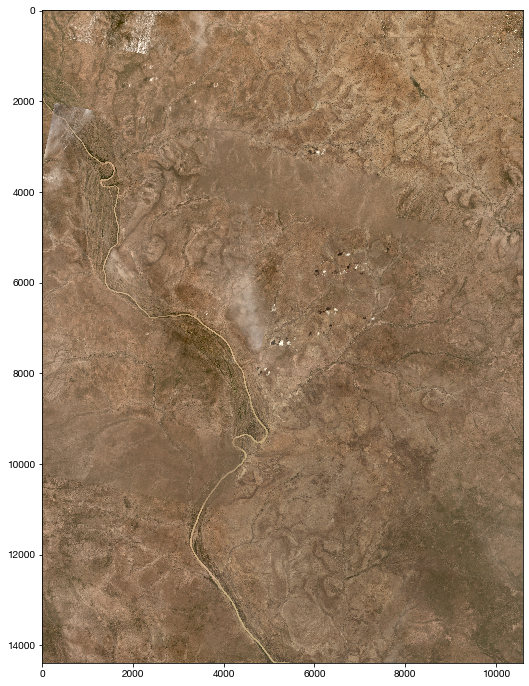

In [37]:
# after merging
renamed = imageio.imread('../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/region0_2017_04.tif')
print(renamed.shape)
fig, ax = plt.subplots(1, figsize=(12,12))
plt.imshow(renamed[:,:,:3])
plt.show()

(14382, 10588, 4)


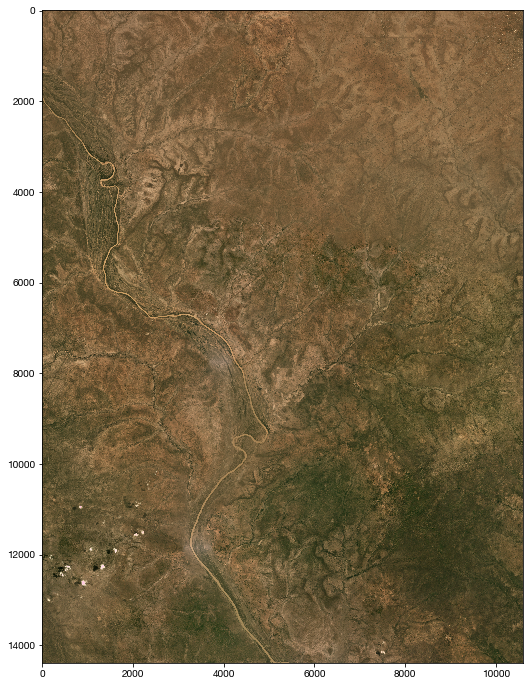

In [36]:
# after merging
renamed = imageio.imread('../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged_2019/region0_2019_04.tif')
print(renamed.shape)
fig, ax = plt.subplots(1, figsize=(12,12))
plt.imshow(renamed[:,:,:3])
plt.show()

(267, 265, 4)


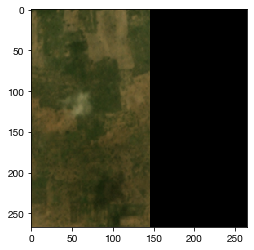

In [28]:
# after merging
renamed = imageio.imread(
    '../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2017_08/04476_2017_08_region4.tif')
print(renamed.shape)
plt.imshow(renamed[:,:,:3])
plt.show()

(267, 265, 4)


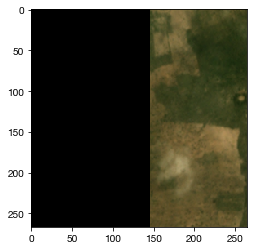

In [43]:
renamed = imageio.imread(
    '../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2019_08/04476_2019_08_region5.tif')
print(renamed.shape)
plt.imshow(renamed[:,:,:3])
plt.show()

(267, 265, 4)


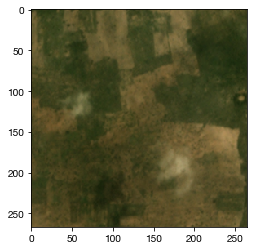

In [42]:
renamed = imageio.imread(
    '../data/planet/ghana/udry/monthly_mosaics_renamed_clipped_merged/2019_08/04476_2019_08.tif')
print(renamed.shape)
plt.imshow(renamed[:,:,:3])
plt.show()